In [ ]:
!pip install nilearn

In [ ]:
from nilearn import datasets
from nilearn.datasets import load_mni152_template
from nilearn.image import resample_to_img
from nilearn import masking
from nilearn import image as nimg
from nilearn import plotting
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import MultiTaskLasso

In [ ]:
adhd_dataset = datasets.fetch_adhd(n_subjects=2)

In [ ]:
print(nimg.load_img(adhd_dataset.func[0]).shape)

(61, 73, 61, 176)


In [ ]:
#параметры сканирования
t_r = 2.0
slice_time_ref = 0.0
n_scans = 176

In [ ]:
#чтобы получилось число вокселей как у них в работе
template = load_mni152_template(resolution=4)
mask_img = masking.compute_epi_mask(template)
print(mask_img.get_fdata().sum())

29264.0


In [ ]:
#приводим к темлпейту картинку
resampled_func = resample_to_img(adhd_dataset.func[0], template)

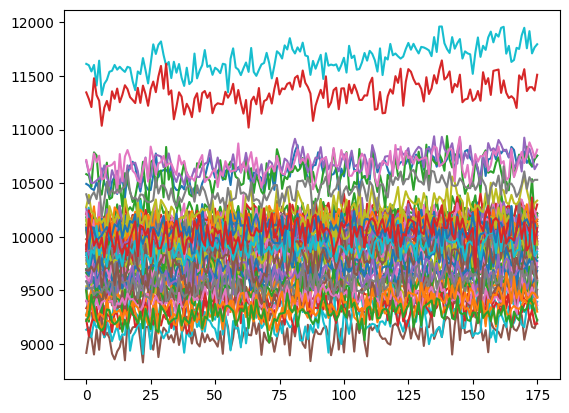

In [ ]:
#так выглядят исходные серии и мне кажется перед сеткой надо с ними работать
func_no_clean = nimg.clean_img(resampled_func, detrend=False, standardize=False,
                               mask_img=mask_img)
plt.plot(func_no_clean.slicer[30:34,36:40,24:28,:].get_fdata().reshape(-1,176).T);

/usr/local/lib/python3.10/dist-packages/nilearn/image/image.py:1272: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  data = signal.clean(


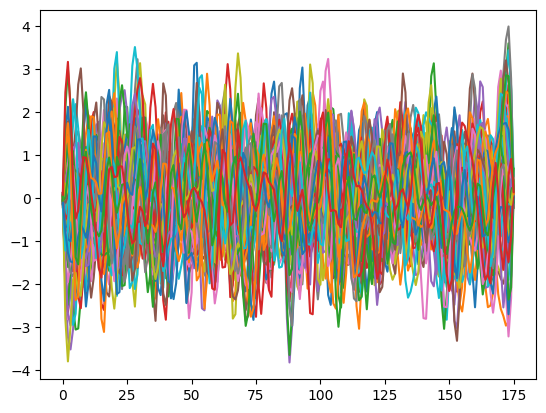

In [ ]:
#пишут что уже убрали конфаунды, допустим, все равно данных нет толком,
#но обычно используют полосовой фильтр при обработке, можно попробовать убрать и добавить, добавила еще нормализацию
func_clean = nimg.clean_img(resampled_func, detrend=False, standardize=True,
                               mask_img=mask_img, low_pass=0.1,high_pass=0.01, t_r=2.0)
plt.plot(func_clean.slicer[30:34,36:40,24:28,:].get_fdata().reshape(-1,176).T);

In [ ]:
# в итоге в вектор нам нужно
masked_data = masking.apply_mask(func_clean, mask_img)

In [ ]:
masked_data.shape

(176, 29264)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size):
        super(Encoder, self).__init__()
        self.linear = nn.Linear(input_size, 512)
        self.lstm1 = nn.LSTM(512, 256)
        self.lstm2 = nn.LSTM(256, 100)
        self.linear_mu = nn.Linear(100, 100)
        self.linear_sigma = nn.Linear(100, 100)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = self.linear(x)
        x = self.lstm1(x)[0]
        x = self.lstm2(x)[0]
        mu = self.linear_mu(x)
        sigma = torch.exp(self.linear_sigma(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).mean()
        return z

class Decoder(nn.Module):
    def __init__(self, input_size):
        super(Decoder, self).__init__()
        self.lstm1 = nn.LSTM(100, 256)
        self.lstm2 = nn.LSTM(256, 512)
        self.linear = nn.Linear(512, input_size)
    def forward(self, x):
        x = self.lstm1(x)[0]
        x = self.lstm2(x)[0]
        return self.linear(x)

class VAE(nn.Module):
    def __init__(self, input_size):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_size)
        self.decoder = Decoder(input_size)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.linear1 = nn.Linear(input_size, 512)
        self.lstm1 = nn.LSTM(512, 256)
        self.lstm2 = nn.LSTM(256, 100)
        self.linear2 = nn.Linear(100, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.lstm1(x)[0]
        x = self.lstm2(x)[0]
        x = self.linear2(x)
        return x

In [ ]:
dataloader = torch.utils.data.DataLoader(masked_data, batch_size=64, shuffle=True)
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
device

device(type='cuda', index=0)

In [ ]:
vae = VAE(masked_data.shape[1]).to(device)
discriminator = Discriminator(masked_data.shape[1]).to(device)
optimizer_vae = optim.Adam(vae.parameters(), lr=0.0002)
criterion_vae = nn.BCELoss()
optimizer_discrim = optim.SGD(discriminator.parameters(), lr=1e-3)
criterion_discrim = nn.BCELoss()

In [ ]:
"""
real_label = 1.
fake_label = 0.
D_losses = []
VAE_losses = []
iters = 0
vae_epochs = 1000
n_epochs = 1000
discrim_epochs = 3
print_loss = 100 # print loss every print_loss epochs

def train_vae():
    for epoch in range(vae_epochs):
        for i, x in enumerate(dataloader, 0):
            x = x.to(device) # GPU
            optimizer_vae.zero_grad()
            x_hat = vae(x)
            loss = ((x - x_hat)**2).mean() + vae.encoder.kl
            loss.backward()
            optimizer_vae.step()
            VAE_losses.append(loss.item())
            if i == 2 and epoch % print_loss == 0:
                print('[Epoch %d/%d]\tLoss_VAE: %.4f, MSE: %.4f, D_KL: %.4f'
              % (epoch, n_epochs, loss.item(), ((x - x_hat)**2).mean().item(), vae.encoder.kl.item()))

def train():
    for epoch in range(n_epochs):
        for d_epoch in range(discrim_epochs):
            for i, data in enumerate(dataloader, 0):
                discriminator.zero_grad()
                real_cpu = data.to(device)
                b_size = real_cpu.size(0)
                label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
               # print(real_cpu)
                output = discriminator(real_cpu).view(-1)
                errD_real = criterion_discrim(output, label)
                errD_real.backward()
                D_x = output.mean().item()
                noise = torch.randn(b_size, 100, device=device)
                fake = vae.decoder(noise)
                label.fill_(fake_label)
                output = discriminator(fake.detach()).view(-1)
                errD_fake = criterion_discrim(output, label)
                errD_fake.backward()
                D_G_z1 = output.mean().item()
                errD = errD_real + errD_fake
                optimizer_discrim.step()
                D_losses.append(errD.item())
                if i == 2 and epoch % print_loss == 0:
                    print('[Epoch %d/%d][%d/%d]\tLoss_D: %.4f\tMean prediction on true brains: %.4f\tMean prediction on generated brains: %.4f'
                  % (epoch, n_epochs, d_epoch + 1, discrim_epochs,
                     errD.item(), D_x, D_G_z1))
                    # Save Losses for plotting later
        for i, x in enumerate(dataloader, 0):
            x = x.to(device) # GPU
            optimizer_vae.zero_grad()
            x_hat = vae(x)
            loss = ((x - x_hat)**2).mean() + vae.encoder.kl
            loss.backward()
            optimizer_vae.step()
            VAE_losses.append(loss.item())
            if i == 2 and epoch % print_loss == 0:
                print('[Epoch %d/%d]\tLoss_VAE: %.4f, MSE: %.4f, D_KL: %.4f'
              % (epoch, n_epochs, loss.item(), ((x - x_hat)**2).mean().item(), vae.encoder.kl.item()))
              """

"\nreal_label = 1.\nfake_label = 0.\nD_losses = []\nVAE_losses = []\niters = 0\nvae_epochs = 1000\nn_epochs = 1000\ndiscrim_epochs = 3\nprint_loss = 100 # print loss every print_loss epochs\n\ndef train_vae():\n    for epoch in range(vae_epochs):\n        for i, x in enumerate(dataloader, 0):\n            x = x.to(device) # GPU\n            optimizer_vae.zero_grad()\n            x_hat = vae(x)\n            loss = ((x - x_hat)**2).mean() + vae.encoder.kl\n            loss.backward()\n            optimizer_vae.step()\n            VAE_losses.append(loss.item())\n            if i == 2 and epoch % print_loss == 0:\n                print('[Epoch %d/%d]\tLoss_VAE: %.4f, MSE: %.4f, D_KL: %.4f'\n              % (epoch, n_epochs, loss.item(), ((x - x_hat)**2).mean().item(), vae.encoder.kl.item()))\n\ndef train():\n    for epoch in range(n_epochs):\n        for d_epoch in range(discrim_epochs):\n            for i, data in enumerate(dataloader, 0):\n                discriminator.zero_grad()\n     

In [ ]:
real_label = 1.
fake_label = 0.
D_losses = []
VAE_losses = []
iters = 0
vae_epochs = 1000
n_epochs = 1000
discrim_epochs = 3
print_loss = 100 # print loss every print_loss epochs
lambda_gp = 10
clip_value = 0.01
def compute_gradient_penalty(discriminator, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1)
    alpha = alpha.expand(real_samples.size())
    alpha = alpha.to(device)

    interpolates = alpha * real_samples + ((1 - alpha) * fake_samples)
    interpolates = interpolates.to(device)
    interpolates.requires_grad_(True)

    d_interpolates = discriminator(interpolates)
    fake = torch.ones(d_interpolates.size()).to(device)

    gradients = torch.autograd.grad(outputs=d_interpolates, inputs=interpolates,
                     grad_outputs=fake, create_graph=True, retain_graph=True,
                     only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def train_vae():
    for epoch in range(vae_epochs):
        for i, x in enumerate(dataloader, 0):
            x = x.to(device) # GPU
            optimizer_vae.zero_grad()
            x_hat = vae(x)
            loss = ((x - x_hat)**2).mean() + vae.encoder.kl
            loss.backward()
            optimizer_vae.step()
            VAE_losses.append(loss.item())
            if i == 2 and epoch % print_loss == 0:
                print('[Epoch %d/%d]\tLoss_VAE: %.4f, MSE: %.4f, D_KL: %.4f'
              % (epoch, n_epochs, loss.item(), ((x - x_hat)**2).mean().item(), vae.encoder.kl.item()))

def train():
    vae.train()
    discriminator.train()
    for epoch in range(n_epochs):
        for d_epoch in range(discrim_epochs):
            for i, data in enumerate(dataloader, 0):
                optimizer_discrim.zero_grad()
                real_cpu = data.to(device)
                b_size = real_cpu.size(0)
                noise = torch.randn(b_size, 100, device=device)
                fake = vae.decoder(noise)

                critic_fake = discriminator(fake)
                critic_real = discriminator(real_cpu)
                with torch.backends.cudnn.flags(enabled=False):
                    gradient_penalty = compute_gradient_penalty(discriminator, real_cpu, fake)
                wasserstein_loss = -torch.mean(critic_real) + torch.mean(critic_fake) + lambda_gp * gradient_penalty
                wasserstein_loss.backward()
                optimizer_discrim.step()
                for param in discriminator.parameters():
                    param.data.clamp_(-clip_value, clip_value)
                D_losses.append(wasserstein_loss.item())
                if i == 2 and epoch % print_loss == 0:
                    print('[Epoch %d/%d][%d/%d]\tLoss_D: %.4f\tWasserstein dist on true brains: %.4f\tWasserstein dist on fake brains: %.4f'
                  % (epoch, n_epochs, d_epoch + 1, discrim_epochs,
                     wasserstein_loss.item(), torch.mean(critic_real), torch.mean(critic_fake)))
                    # Save Losses for plotting later
        for i, x in enumerate(dataloader, 0):
            x = x.to(device) # GPU
            optimizer_vae.zero_grad()
            x_hat = vae(x)
            loss = ((x - x_hat)**2).mean() + vae.encoder.kl
            loss.backward()
            optimizer_vae.step()
            VAE_losses.append(loss.item())
            if i == 2 and epoch % print_loss == 0:
                print('[Epoch %d/%d]\tLoss_VAE: %.4f, MSE: %.4f, D_KL: %.4f'
              % (epoch, n_epochs, loss.item(), ((x - x_hat)**2).mean().item(), vae.encoder.kl.item()))

In [ ]:
train_vae()

[Epoch 0/1000]	Loss_VAE: 1.4701, MSE: 0.9572, D_KL: 0.5130
[Epoch 100/1000]	Loss_VAE: 1.3639, MSE: 1.0169, D_KL: 0.3470
[Epoch 200/1000]	Loss_VAE: 1.4000, MSE: 1.0533, D_KL: 0.3468
[Epoch 300/1000]	Loss_VAE: 1.3568, MSE: 1.0102, D_KL: 0.3466
[Epoch 400/1000]	Loss_VAE: 1.3046, MSE: 0.9334, D_KL: 0.3712
[Epoch 500/1000]	Loss_VAE: 1.3073, MSE: 0.9373, D_KL: 0.3700
[Epoch 600/1000]	Loss_VAE: 1.2262, MSE: 0.8602, D_KL: 0.3660
[Epoch 700/1000]	Loss_VAE: 1.2132, MSE: 0.8333, D_KL: 0.3799
[Epoch 800/1000]	Loss_VAE: 1.2572, MSE: 0.8866, D_KL: 0.3706
[Epoch 900/1000]	Loss_VAE: 1.1924, MSE: 0.8205, D_KL: 0.3719


In [ ]:
train()

[Epoch 0/1000][1/3]	Loss_D: 9.9905	Wasserstein dist on true brains: 0.0095	Wasserstein dist on fake brains: 0.0095
[Epoch 0/1000][2/3]	Loss_D: 9.9904	Wasserstein dist on true brains: 0.0097	Wasserstein dist on fake brains: 0.0095
[Epoch 0/1000][3/3]	Loss_D: 9.9905	Wasserstein dist on true brains: 0.0095	Wasserstein dist on fake brains: 0.0095
[Epoch 0/1000]	Loss_VAE: 1.1831, MSE: 0.8067, D_KL: 0.3764
[Epoch 100/1000][1/3]	Loss_D: 9.9857	Wasserstein dist on true brains: 0.0096	Wasserstein dist on fake brains: 0.0095
[Epoch 100/1000][2/3]	Loss_D: 9.9857	Wasserstein dist on true brains: 0.0096	Wasserstein dist on fake brains: 0.0095
[Epoch 100/1000][3/3]	Loss_D: 9.9856	Wasserstein dist on true brains: 0.0097	Wasserstein dist on fake brains: 0.0095
[Epoch 100/1000]	Loss_VAE: 1.1636, MSE: 0.7922, D_KL: 0.3715
[Epoch 200/1000][1/3]	Loss_D: 9.9790	Wasserstein dist on true brains: 0.0096	Wasserstein dist on fake brains: 0.0094
[Epoch 200/1000][2/3]	Loss_D: 9.9789	Wasserstein dist on true brain

In [ ]:
#vae.load_state_dict(torch.load("vae.pt"))

In [ ]:
#discriminator.load_state_dict(torch.load("discriminator.pt"))

Text(0.5, 1.0, 'Discrim wasserstein loss')

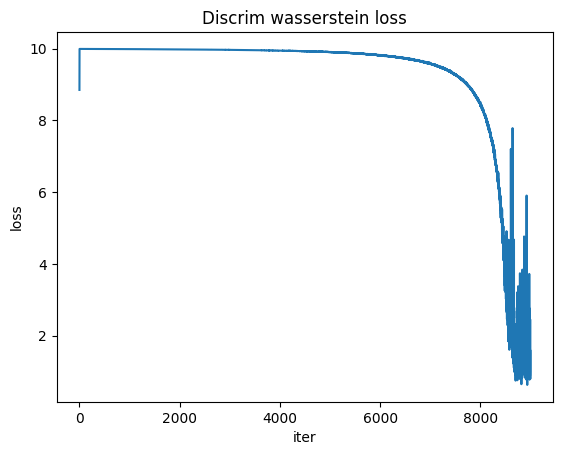

In [ ]:
ax = sns.lineplot(D_losses)
ax.set(xlabel='iter', ylabel='loss')
ax.set_title("Discrim wasserstein loss")

Text(0.5, 1.0, 'VAE loss')

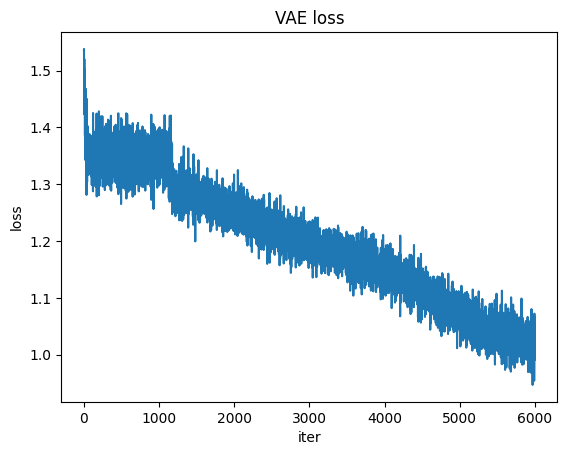

In [ ]:
ax = sns.lineplot(VAE_losses)
ax.set(xlabel='iter', ylabel='loss')
ax.set_title("VAE loss")

In [ ]:
resampled_func = resample_to_img(adhd_dataset.func[1], template)
func_no_clean = nimg.clean_img(resampled_func, detrend=False, standardize=False,
                               mask_img=mask_img)
func_clean = nimg.clean_img(resampled_func, detrend=False, standardize=True,
                               mask_img=mask_img, low_pass=0.1,high_pass=0.01, t_r=2.0)
test_masked_data = masking.apply_mask(func_clean, mask_img)

/usr/local/lib/python3.10/dist-packages/nilearn/image/image.py:1272: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  data = signal.clean(


In [ ]:
vae.eval()
temporal_feats = vae.encoder(torch.Tensor(test_masked_data).to(device)).cpu().detach().numpy()
lasso = MultiTaskLasso(alpha = 1.5) # alpha taken from the paper
lasso.fit(temporal_feats, test_masked_data)
spatial_feats = lasso.coef_.T

In [ ]:
fbn = masking.unmask(spatial_feats, mask_img)

In [ ]:
print(nimg.load_img(fbn).shape)

In [ ]:
print(nimg.load_img(adhd_dataset.func[0]).shape)

In [ ]:
first_fbn = nimg.index_img(fbn, 0)

In [ ]:
plotting.plot_stat_map(first_fbn)

In [ ]:
torch.save(discriminator.state_dict(), "discrim_wgan_gp.pt")

In [ ]:
torch.save(vae.state_dict(), "vae_wgan_gp1.pt")